In [1]:
from rsna_retro.imports import *
from rsna_retro.metadata import *
from rsna_retro.preprocess import *
from rsna_retro.train import *
from rsna_retro.train3d import *

Loading imports


In [2]:
torch.cuda.set_device(1)

In [3]:
dls_feat = get_3d_dls_feat(Meta.df_comb, path=path_feat_384avg, bs=32)

## Model

In [4]:
class SeqHead(nn.Module):
    def __init__(self):
        super().__init__()
        d_model = 2048*2
        self.conv = nn.Sequential(
            ConvLayer(512, 1024, stride=2),
            ConvLayer(1024, 1024, stride=2),
            ConvLayer(1024, d_model, stride=2),
            AdaptiveConcatPool2d(),
#             nn.AdaptiveAvgPool2d(1),
            Flatten()
        )
        
        self.hook = ReshapeBodyHook(self.conv)
        hidden = 96
        self.lstm = nn.LSTM(input_size=d_model*2, hidden_size=hidden, num_layers=2, bidirectional=True)
        self.head = nn.Sequential(
#             nn.Linear(hidden*2,hidden*4),
#             nn.ReLU(),
            nn.Linear(hidden*2,6)
        )
        
    def forward(self, x):
        x = self.conv(x)
        feat, _ = self.lstm(x.transpose(0,1))
        return self.head(feat.transpose(0,1))

In [5]:
m = SeqHead()
name = 'train3d_baseline_feat_lstm'
learn = get_learner(dls_feat, m, name=name)
learn.add_cb(DePadLoss())

In [6]:
# learn.summary()

## Training

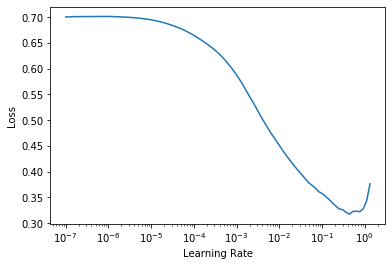

In [9]:
learn.lr_find()

In [ ]:
do_fit(learn, 10, 1e-2)
learn.save(f'runs/{name}-1')

epoch,train_loss,valid_loss,accuracy_multi,accuracy_any,time
0,0.059201,0.077511,0.975038,0.951709,02:14
1,0.059824,0.078984,0.976025,0.957286,01:52
2,0.056121,0.069689,0.977586,0.957298,01:53
3,0.052238,0.071394,0.976914,0.957260,01:55
4,0.051653,0.068963,0.978070,0.957999,01:53
5,0.051239,0.071562,0.978700,0.959144,01:52
6,0.049299,0.069856,0.978184,0.957731,01:55
7,0.046488,0.068662,0.978216,0.957871,01:56
8,0.041862,0.070637,0.978638,0.958852,01:54
9,0.038778,0.071522,0.978528,0.958597,01:52


## Testing

In [ ]:
dls_feat = get_3d_dls_feat(Meta.df_tst, path=path_feat_tst_384avg, bs=32, test=True)

In [ ]:
learn.dls = dls_feat

In [ ]:
preds,targs = learn.get_preds()

In [ ]:
preds.shape, preds.min(), preds.max()

In [ ]:
pred_csv = submission(Meta.df_tst, preds, fn=sub_fn)

In [ ]:
api.competition_submit(f'{sub_fn}.csv', name, 'rsna-intracranial-hemorrhage-detection')

In [ ]:
api.competitions_submissions_list('rsna-intracranial-hemorrhage-detection')[0]